1️⃣【第四周作业】

1. 搭建的神经网络，使用olivettiface数据集进行训练。
2. 结合归一化和正则化来优化网络模型结构，观察对比loss结果。
3. 尝试不同optimizer对模型进行训练，观察对比loss结果。
4. 注册kaggle并尝试激活Accelerator，使用GPU加速模型训练。

## 作业实验结果
1. 已成功使用简单的神经网络对 olivettiface数据集进行训练 ，训练集最高时达到了97%，但是测试后发现，测试集准确率不稳定，最高处达到了80%左右；整体效果不是很理想。
2. 增加 归一化 处理数据层后，测试数据集的准确率有很大提升，较为稳定，波动小。
3. 增加 正则化 处理数据后，发现测试数据集的结果不如以往，不太了解什么因素导致。
4. 在学习率为0.001的情况下，使用了三种优化器进行优化
+ ‌SGD+Momentum 优化器准确率较高，但是处理速度稍慢；
+ RMSprop‌ 的收敛速度很快，但是准确率没有那么高，可能是学习率没调整的原因；
+ Adam 的收敛速度较快，准确率也较高。

In [167]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader,TensorDataset

In [187]:
# 检查设备
device ="cuda" if torch.cuda.is_available() else "cpu" 
print(f"使用 {device} 设备")

使用 cpu 设备


In [186]:
# 自定义数据集类
class OlivettiDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        """
        参数:
        data: numpy数组形状为 (n_samples, 64, 64)
        labels: numpy数组形状为 (n_samples,)
        transform: 可选的数据增强变换
        """
        # 调整维度顺序并添加通道维度 (H, W) -> (C, H, W)
        self.images = torch.from_numpy(data).unsqueeze(1).float()  # shape (400, 1, 64, 64)
        self.labels = torch.from_numpy(labels).long()              # shape (400,)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [185]:
# 数据加载函数
def load_data(batch_size, train_size):
    """加载原始数据
        经过测试发现， olivetti_faces 下面有 三个属性
        olivetti_faces.data 是一个一维数组，存储所有数据，但是只有一条
        olivetti_faces.images 是一个二维数组，存储所有数据，(64, 64)
        olivetti_faces.target 是一个一维数组，存储结果数据
    """

    test_size = 1 - train_size
    olivetti = fetch_olivetti_faces(
        data_home='./face_data',
        shuffle=True
    )
    # 数据预处理
    X = olivetti.data.reshape(-1, 1, 64, 64)  # 保持二维结构 (400, 64, 64)
    X = X.astype(np.float32)
    y = olivetti.target.astype(np.int64)

    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=olivetti.target, random_state=42
    )
    # 转换为PyTorch张量
    X_train_tensor = torch.from_numpy(X_train)
    y_train_tensor = torch.from_numpy(y_train)
    X_test_tensor = torch.from_numpy(X_test)
    y_test_tensor = torch.from_numpy(y_test)

    # 创建Dataset和DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    # # 创建数据集对象
    # train_dataset = OlivettiDataset(X_train, y_train)
    # test_dataset = OlivettiDataset(X_test, y_test)
    # # 创建DataLoader
    # train_loader = DataLoader(
    #     train_dataset,
    #     batch_size=batch_size,
    #     shuffle=True
    # )
    # test_loader = DataLoader(
    #     test_dataset,
    #     batch_size=batch_size,
    #     shuffle=False
    # )

    print(f"本次训练的数据集数量为 {X_train.size};  测试的数据集数量为 {X_test.size};")
    return train_loader, test_loader



In [184]:
# 训练模型
def train_model(model,optimizer,criterion,train_loader,test_loader,epochs):
    train_loss = [] # 记录差值
    train_accuary = []# 记录准确率
    test_loss = [] # 记录差值
    test_accuary = []# 记录准确率

    print(f"Model Train is start !")
    
    for epoch in range(epochs):
        # 开始训练
        model.train()
        train_loss_data = 0.0
        train_num = 0
        train_num_right = 0

        for images,labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() # 梯度值清零
            model_output = model(images)# 模型对输入数据的预测结果，输出张量。其实就是调用了前向传播，这个地方有封装
            loss = criterion(model_output,labels)# 将 model_output 与真实标签 labels 输入损失函数（如交叉熵损失）

            loss.backward() # 反向传播计算得到每个参数的梯度值w
            optimizer.step() # 根据梯度更新网络w参数

            train_loss_data += loss.item() # 统计损失值
            p, predicted = torch.max(model_output.data, 1)# 从模型输出的张量当中提取预测结果，p 是最大值，predict是预测类别索引
            train_num += labels.size(0)
            train_num_right += (predicted == labels).sum().item()
        
        # 计算训练集指标
        train_epoch_loss = train_loss_data / len(train_loader)# 平均损失值
        train_epoch_acc = train_num_right / train_num # 正确率
        train_loss.append(train_epoch_loss) # 记录此次训练的损失值
        train_accuary.append(train_epoch_acc) # 记录此次训练的正确概率

        # 开始验证
        model.eval()# 模型切换到评估模式
        test_loss_data = 0.0
        test_num = 0
        test_num_right = 0
        with torch.no_grad():#禁用梯度计算
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                model_output = model(images)# 模型对输入数据的预测结果，输出张量。其实就是调用了前向传播，这个地方有封装
                loss = criterion(model_output,labels)# 将 model_output 与真实标签 labels 输入损失函数（如交叉熵损失）
                test_loss_data += loss.item() # 统计损失值
                p, predicted = torch.max(model_output.data, 1)# 从模型输出的张量当中提取预测结果，p 是最大值，predict是预测类别索引
                test_num += labels.size(0)
                test_num_right += (predicted == labels).sum().item()
        # 计算验证集指标
        test_epoch_loss = test_loss_data / len(test_loader)# 平均损失值
        test_epoch_acc = test_num_right / test_num # 正确率
        test_loss.append(test_epoch_loss) # 记录此次训练的损失值
        test_accuary.append(test_epoch_acc) # 记录此次训练的正确概率

        print(f"Epoch-{epoch+1}:  train loss = {train_epoch_loss:.4f}, train accuary = {train_epoch_acc:.4f} ; test loss = {test_epoch_loss:.4f}, test accuary = {test_epoch_acc:.4f}  ;")
    print(f"Model Train is end !")
    print(f"------------------------------------------------------------------------------------------------------")
    
    return train_loss, train_accuary, test_loss, test_accuary

In [183]:
# 训练结果数据可视化
def view_data(train_accuary,test_accuary,train_loss,test_loss):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuary, label='Train Accuary')
    plt.plot(test_accuary, label='test Accuary')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(test_loss, label='Test Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()


In [175]:
# 主要流程提取,控制变量为 模型，优化器和损失函数，便于后续使用
def train_main_progress(model,criterion,optimizer):
    # 定义超参数
    epochs = 100
    batch_size = 32
    train_size = 0.8

    # 确认数据集
    train_loader,test_loader = load_data(batch_size,train_size)

    # 评估模型  
    train_loss, train_accuary, test_loss, test_accuary = train_model(model,optimizer,criterion,train_loader,test_loader,epochs)

    # 数据可视化
    view_data(train_accuary,test_accuary,train_loss,test_loss)


本次训练的 模型为 FaceCNN , 损失函数为 交叉熵损失函数 , 优化器为 Adam
本次训练的数据集数量为 1310720;  测试的数据集数量为 327680;
Model Train is start !
Epoch-1:  train loss = 3.6669, train accuary = 0.0375 ; test loss = 3.6978, test accuary = 0.0500  ;
Epoch-2:  train loss = 3.4038, train accuary = 0.1094 ; test loss = 3.7239, test accuary = 0.0250  ;
Epoch-3:  train loss = 3.3230, train accuary = 0.1156 ; test loss = 3.7599, test accuary = 0.0375  ;
Epoch-4:  train loss = 3.2132, train accuary = 0.1656 ; test loss = 3.7066, test accuary = 0.0500  ;
Epoch-5:  train loss = 3.1003, train accuary = 0.2188 ; test loss = 3.4806, test accuary = 0.0250  ;
Epoch-6:  train loss = 3.0553, train accuary = 0.2094 ; test loss = 3.2531, test accuary = 0.0875  ;
Epoch-7:  train loss = 2.9123, train accuary = 0.2875 ; test loss = 2.9480, test accuary = 0.2500  ;
Epoch-8:  train loss = 2.8565, train accuary = 0.2844 ; test loss = 2.9101, test accuary = 0.2750  ;
Epoch-9:  train loss = 2.7728, train accuary = 0.3000 ; test loss = 2.7534, test ac

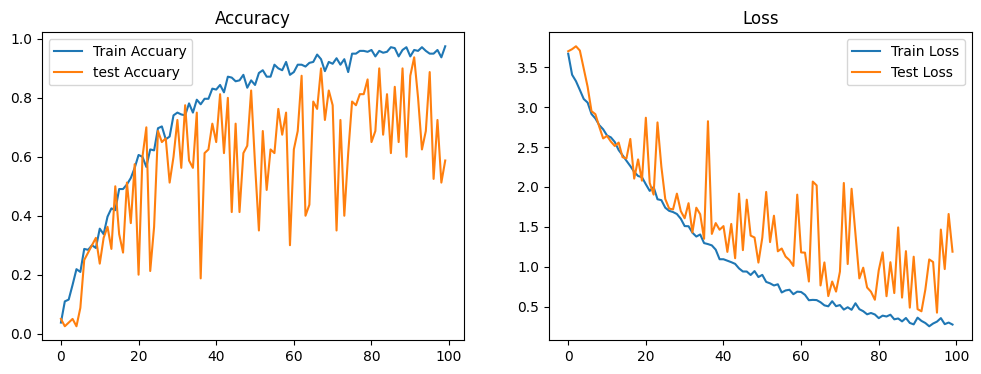

In [192]:
# 定义CNN模型
class FaceCNN(nn.Module):
    def __init__(self):
        super(FaceCNN, self).__init__()
        self.net = nn.Sequential(
            # 卷积层1
            nn.Conv2d(
                in_channels=1,    # 输入通道数（输入数据的深度）
                out_channels=32,  # 输出通道数（卷积核数量/提取的特征图数量）
                kernel_size=3,     # 卷积核大小（3x3）
            ),  # 输出: (32, 62, 62)
            # 归一化
            nn.BatchNorm2d(32),
            nn.ReLU(),# 激活函数
            nn.MaxPool2d(2),# 输出: (32, 31, 31)     

            nn.Conv2d(32, 64, 3),    # 输出: (64, 29, 29)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),         # 输出: (64, 14, 14)

            nn.Conv2d(64, 128, 3),   # 输出: (128, 12, 12)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1), # 全局平均池化
            nn.Flatten(),
            nn.Dropout(0.5),         # 正则化
            nn.Linear(128, 40)
        )
    def forward(self, x):
        return self.net(x)

# 主程序
if __name__ == "__main__":

    # 学习率
    lr = 1e-3

    # 使用 FaceCNN 模型
    model = FaceCNN().to(device)
    # 定义损失函数
    criterion = nn.CrossEntropyLoss()
    # 定义优化器
    optimizer = torch.optim.Adam(model.parameters(), lr)

    print("本次训练的 模型为 FaceCNN , 损失函数为 交叉熵损失函数 , 优化器为 Adam")
    
    # 训练模型
    train_main_progress(model,criterion,optimizer)

本次训练的 模型为 NeuralNetwork 增加了归一化 , 损失函数为 交叉熵损失函数 , 优化器为 Adam
本次训练的数据集数量为 1310720;  测试的数据集数量为 327680;
Model Train is start !
Epoch-1:  train loss = 2.7213, train accuary = 0.3875 ; test loss = 4.1098, test accuary = 0.0625  ;
Epoch-2:  train loss = 1.1603, train accuary = 0.9094 ; test loss = 1.9025, test accuary = 0.4750  ;
Epoch-3:  train loss = 0.5855, train accuary = 0.9781 ; test loss = 1.1040, test accuary = 0.8125  ;
Epoch-4:  train loss = 0.2866, train accuary = 1.0000 ; test loss = 0.7639, test accuary = 0.8375  ;
Epoch-5:  train loss = 0.1567, train accuary = 1.0000 ; test loss = 0.5287, test accuary = 0.9250  ;
Epoch-6:  train loss = 0.0959, train accuary = 1.0000 ; test loss = 0.4728, test accuary = 0.9125  ;
Epoch-7:  train loss = 0.0593, train accuary = 1.0000 ; test loss = 0.3697, test accuary = 0.9250  ;
Epoch-8:  train loss = 0.0426, train accuary = 1.0000 ; test loss = 0.3105, test accuary = 0.9375  ;
Epoch-9:  train loss = 0.0355, train accuary = 1.0000 ; test loss = 0.

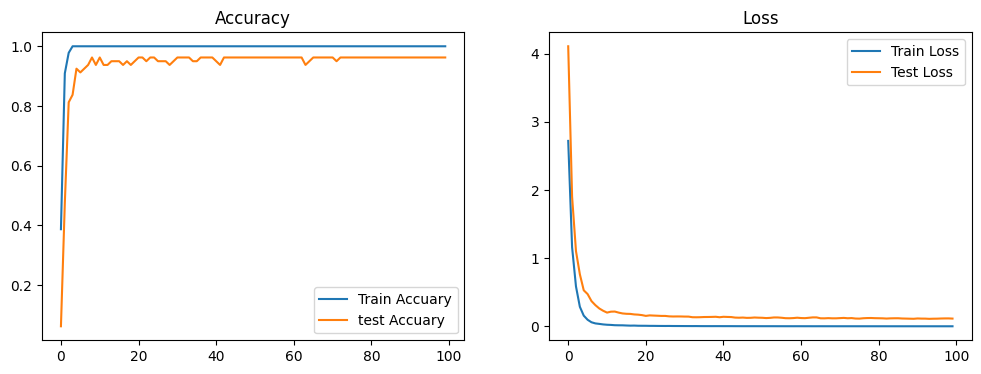

In [ ]:
# 定义神经网络模型，归一化模型，batchNorm, 主要目的是加速收敛，减少过拟合
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork,self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack  = nn.Sequential(
            nn.Flatten(),                   # 展平 64x64 图像 → 4096 维
            nn.Linear(4096, 512),           # 全连接层1
            nn.BatchNorm1d(512),
            nn.ReLU(),                      # 激活函数
            nn.Linear(512, 40)              # 输出层（40类）
        )
       
    # 前向传播
    def forward(self,x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits  

# 主程序
if __name__ == "__main__":

    # 学习率
    lr = 1e-3

    # 使用 NeuralNetwork 模型
    model = NeuralNetwork().to(device)
    # 定义损失函数
    criterion = nn.CrossEntropyLoss()
    # 定义优化器
    optimizer = torch.optim.Adam(model.parameters(), lr)

    print("本次训练的 模型为 NeuralNetwork 增加了归一化 , 损失函数为 交叉熵损失函数 , 优化器为 Adam")
    
    # 训练模型
    train_main_progress(model,criterion,optimizer)

本次训练的 模型为 NeuralNetwork 增加了归一化和正则化 , 损失函数为 交叉熵损失函数 , 优化器为 Adam
本次训练的数据集数量为 1310720;  测试的数据集数量为 327680;
Model Train is start !
Epoch-1:  train loss = 2.8898, train accuary = 0.3094 ; test loss = 4.9630, test accuary = 0.0250  ;
Epoch-2:  train loss = 1.5832, train accuary = 0.7812 ; test loss = 2.2732, test accuary = 0.2500  ;
Epoch-3:  train loss = 0.9540, train accuary = 0.9219 ; test loss = 1.2342, test accuary = 0.7750  ;
Epoch-4:  train loss = 0.5950, train accuary = 0.9688 ; test loss = 1.0430, test accuary = 0.7250  ;
Epoch-5:  train loss = 0.3668, train accuary = 0.9969 ; test loss = 0.8809, test accuary = 0.8500  ;
Epoch-6:  train loss = 0.2480, train accuary = 0.9938 ; test loss = 0.8932, test accuary = 0.8125  ;
Epoch-7:  train loss = 0.1672, train accuary = 1.0000 ; test loss = 0.6435, test accuary = 0.8750  ;
Epoch-8:  train loss = 0.1105, train accuary = 1.0000 ; test loss = 0.5049, test accuary = 0.9125  ;
Epoch-9:  train loss = 0.0944, train accuary = 1.0000 ; test loss 

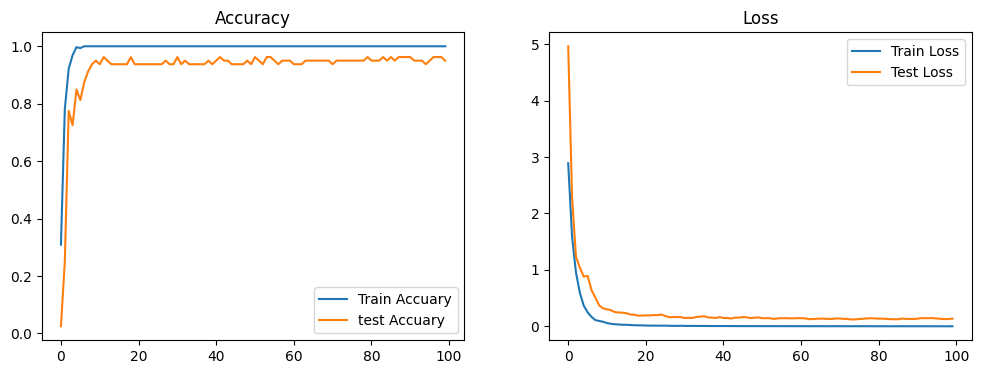

In [204]:
# 正则化，作用是抑制过拟合，提升模型泛华能力，也就是能够照顾到更多的数据
# 定义神经网络模型
class NeuralNetworkDropout(nn.Module):
    def __init__(self):
        super(NeuralNetworkDropout,self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Flatten(),          # 展平 64x64 图像 → 4096 维
            nn.Linear(4096, 512),  # 全连接层1
            nn.BatchNorm1d(512),   # 批量归一化
            nn.ReLU(),
            nn.Dropout(0.5),       # 新增 Dropout ← 随机屏蔽30%神经元‌:ml-citation{ref="5,6" data="citationList"}
            nn.Linear(512, 40)
        )
       
    # 前向传播
    def forward(self,x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits  

# 主程序
if __name__ == "__main__":

    # 学习率
    lr = 1e-3

    # 使用 NeuralNetworkDropout 模型
    model = NeuralNetworkDropout().to(device)
    # 定义损失函数
    criterion = nn.CrossEntropyLoss()
    # 定义优化器
    optimizer = torch.optim.Adam(model.parameters(), lr)

    print("本次训练的 模型为 NeuralNetwork 增加了归一化和正则化 , 损失函数为 交叉熵损失函数 , 优化器为 Adam")
    
    # 训练模型
    train_main_progress(model,criterion,optimizer)

本次训练的 模型为 NeuralNetworkDropout 增加了归一化和正则化 , 损失函数为 交叉熵损失函数 , 优化器为  RMSprop 
本次训练的数据集数量为 1310720;  测试的数据集数量为 327680;
Model Train is start !
Epoch-1:  train loss = 2.8199, train accuary = 0.3344 ; test loss = 3.3230, test accuary = 0.1125  ;
Epoch-2:  train loss = 1.1422, train accuary = 0.8625 ; test loss = 2.1238, test accuary = 0.4750  ;
Epoch-3:  train loss = 0.5671, train accuary = 0.9719 ; test loss = 3.0803, test accuary = 0.2875  ;
Epoch-4:  train loss = 0.3355, train accuary = 0.9875 ; test loss = 1.8012, test accuary = 0.4000  ;
Epoch-5:  train loss = 0.1938, train accuary = 0.9969 ; test loss = 1.7153, test accuary = 0.5125  ;
Epoch-6:  train loss = 0.1327, train accuary = 1.0000 ; test loss = 3.7457, test accuary = 0.2375  ;
Epoch-7:  train loss = 0.1248, train accuary = 1.0000 ; test loss = 1.3925, test accuary = 0.6250  ;
Epoch-8:  train loss = 0.0588, train accuary = 0.9969 ; test loss = 1.8820, test accuary = 0.4500  ;
Epoch-9:  train loss = 0.0586, train accuary = 1.0000 

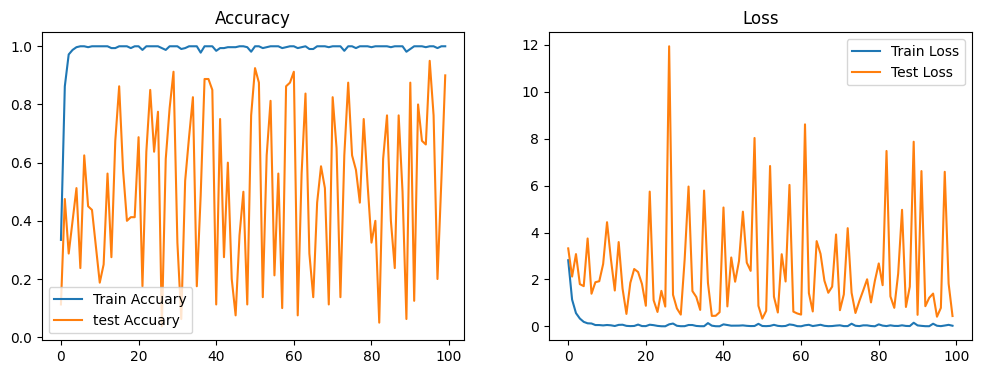

In [ ]:
# 主程序，使用 RMSprop 优化器
if __name__ == "__main__":

    # 学习率
    lr = 1e-3

    # 使用 NeuralNetworkDropout 模型
    model = NeuralNetworkDropout().to(device)
    # 定义损失函数
    criterion = nn.CrossEntropyLoss()
    # 定义优化器
    optimizer = torch.optim.RMSprop(
        model.parameters(),
        lr=0.001,       # 学习率可提升至 0.002-0.005 加速收敛‌:ml-citation{ref="3" data="citationList"}
        alpha=0.9,      # 平滑系数，控制历史梯度影响‌:ml-citation{ref="3" data="citationList"}
        momentum=0.1,   # 添加动量项增强稳定性‌:ml-citation{ref="3,8" data="citationList"}
        weight_decay=1e-3
    )
    print("本次训练的 模型为 NeuralNetworkDropout 增加了归一化和正则化 , 损失函数为 交叉熵损失函数 , 优化器为  RMSprop ")
    
    # 训练模型
    train_main_progress(model,criterion,optimizer)

本次训练的 模型为 NeuralNetworkDropout 增加了归一化和正则化 , 损失函数为 交叉熵损失函数 , 优化器为  SGD with Momentum 
本次训练的数据集数量为 1310720;  测试的数据集数量为 327680;
Model Train is start !
Epoch-1:  train loss = 2.8797, train accuary = 0.2844 ; test loss = 3.4756, test accuary = 0.0250  ;
Epoch-2:  train loss = 1.2684, train accuary = 0.8688 ; test loss = 2.3623, test accuary = 0.4125  ;
Epoch-3:  train loss = 0.6282, train accuary = 0.9688 ; test loss = 1.2269, test accuary = 0.8375  ;
Epoch-4:  train loss = 0.3225, train accuary = 0.9875 ; test loss = 0.7326, test accuary = 0.9250  ;
Epoch-5:  train loss = 0.1782, train accuary = 1.0000 ; test loss = 0.5219, test accuary = 0.9375  ;
Epoch-6:  train loss = 0.1139, train accuary = 1.0000 ; test loss = 0.3942, test accuary = 0.9625  ;
Epoch-7:  train loss = 0.0860, train accuary = 1.0000 ; test loss = 0.3366, test accuary = 0.9500  ;
Epoch-8:  train loss = 0.0758, train accuary = 1.0000 ; test loss = 0.3267, test accuary = 0.9250  ;
Epoch-9:  train loss = 0.0561, train accuary

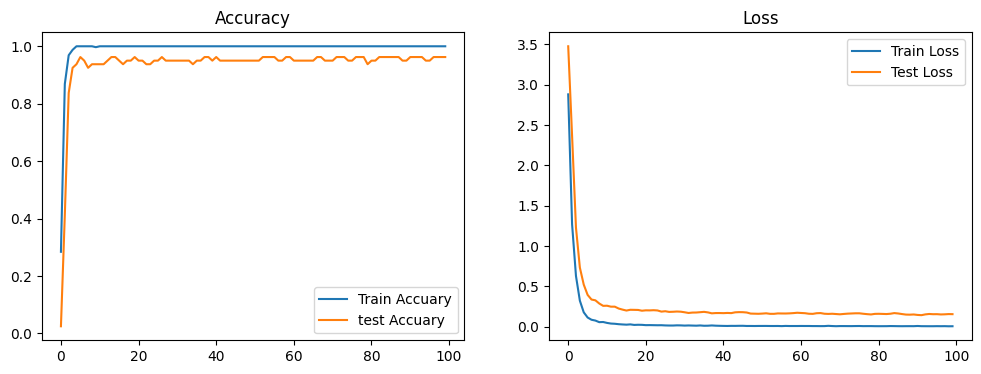

In [205]:
# 主程序,使用 SGD with Momentum 优化器
if __name__ == "__main__":

    # 学习率
    lr = 1e-3

    # 使用 NeuralNetworkDropout 模型
    model = NeuralNetworkDropout().to(device)
    # 定义损失函数
    criterion = nn.CrossEntropyLoss()
    # 定义优化器
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=0.01,        # 初始学习率需高于 Adam‌:ml-citation{ref="7,8" data="citationList"}
        momentum=0.9,   # 动量参数，积累历史梯度方向‌:ml-citation{ref="7" data="citationList"}
        nesterov=True,   # 启用 Nesterov 加速梯度更新‌:ml-citation{ref="8" data="citationList"}
        weight_decay=1e-3
    )
    print("本次训练的 模型为 NeuralNetworkDropout 增加了归一化和正则化 , 损失函数为 交叉熵损失函数 , 优化器为  SGD with Momentum ")
    
    # 训练模型
    train_main_progress(model,criterion,optimizer)